<a href="https://colab.research.google.com/github/Suriyaskrs/AQI_Visualization/blob/main/AQI_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AQI Visualization

In [ ]:
# Install required packages
!pip install seaborn matplotlib scikit-learn shap

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

In [ ]:

# Set the style for plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Download the data
url = "https://raw.githubusercontent.com/Hari20032005/aqi-collector/main/data/aqi_data.csv"
df = pd.read_csv(url)


In [ ]:
# Display basic information about the dataset
print("Dataset Information:")
print(f"Number of records: {len(df)}")
print(f"Number of cities: {df['city'].nunique()}")
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Columns: {', '.join(df.columns)}")

# Display basic statistics
print("\nBasic Statistics:")
df.describe()

Dataset Information:
Number of records: 20510
Number of cities: 10
Time range: 2025-01-13 02:36:26 to 2025-04-12 09:16:27
Columns: city, timestamp, aqi, co, no2, o3, so2, pm2_5, pm10, temperature, humidity, collection_status

Basic Statistics:


,aqi,co,no2,o3,so2,pm2_5,pm10,temperature,humidity
count,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000,20508.000000
mean,4.134630,1006.220342,25.239673,89.424202,22.257513,101.701386,130.996178,25.219869,50.931051
std,0.982146,921.225872,26.992661,58.620665,23.404304,101.279417,121.591695,6.052944,23.863623
min,1.000000,88.900000,0.010000,0.000000,0.070000,1.640000,2.920000,7.600000,2.000000
25%,3.000000,500.680000,8.910000,45.420000,7.990000,39.647500,58.337500,21.040000,32.000000
50%,4.000000,727.650000,17.310000,82.250000,15.140000,69.590000,92.925000,25.960000,50.000000
75%,5.000000,1148.220000,31.190000,128.750000,27.660000,125.302500,156.710000,29.350000,70.000000
max,5.000000,11856.080000,320.790000,703.810000,297.550000,1183.450000,1348.590000,41.790000,100.000000


In [ ]:

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['week_of_year'] = df['timestamp'].dt.isocalendar().week

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Check for duplicate records
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate records: {duplicates}")

# Distribution of AQI values by city
print("\nAQI distribution by city:")
aqi_by_city = df.groupby('city')['aqi'].agg(['mean', 'min', 'max', 'std']).sort_values('mean', ascending=False)
print(aqi_by_city)



Missing values in each column:
city                 0
timestamp            0
aqi                  2
co                   2
no2                  2
o3                   2
so2                  2
pm2_5                2
pm10                 2
temperature          2
humidity             2
collection_status    0
date                 0
hour                 0
day                  0
month                0
day_of_week          0
week_of_year         0
dtype: int64

Number of duplicate records: 0

AQI distribution by city:
               mean  min  max       std
city                                   
Patna      4.678206  2.0  5.0  0.636153
Kolkata    4.641151  1.0  5.0  0.901459
Delhi      4.539737  2.0  5.0  0.723646
Lucknow    4.502439  2.0  5.0  0.698771
Mumbai     4.463189  1.0  5.0  0.813895
Hyderabad  4.184390  1.0  5.0  0.903413
Jaipur     4.029742  2.0  5.0  0.861419
Chennai    3.550951  1.0  5.0  1.025867
Ahmedabad  3.548513  2.0  5.0  0.898216
Bengaluru  3.208191  1.0  5.0  0.907987


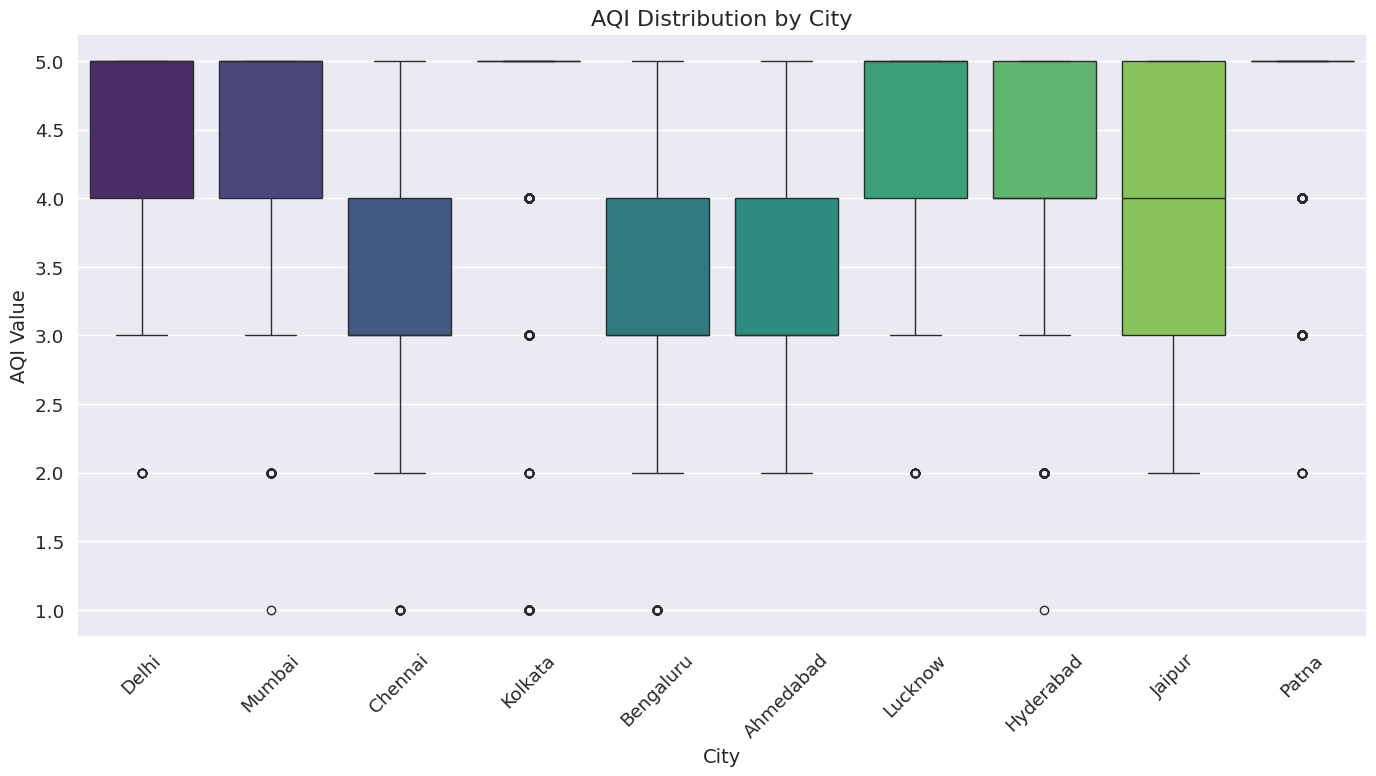

In [ ]:

# Create a custom colormap for AQI (green to red)
colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#99004c', '#7e0023']
aqi_cmap = LinearSegmentedColormap.from_list('aqi_cmap', colors, N=256)

"""
# STANDARD VISUALIZATIONS
"""

# 1. AQI Distribution by City (Boxplot)
plt.figure(figsize=(14, 8))
sns.boxplot(x='city', y='aqi', data=df, hue='city', palette='viridis', legend=False)
plt.title('AQI Distribution by City', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('AQI Value', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

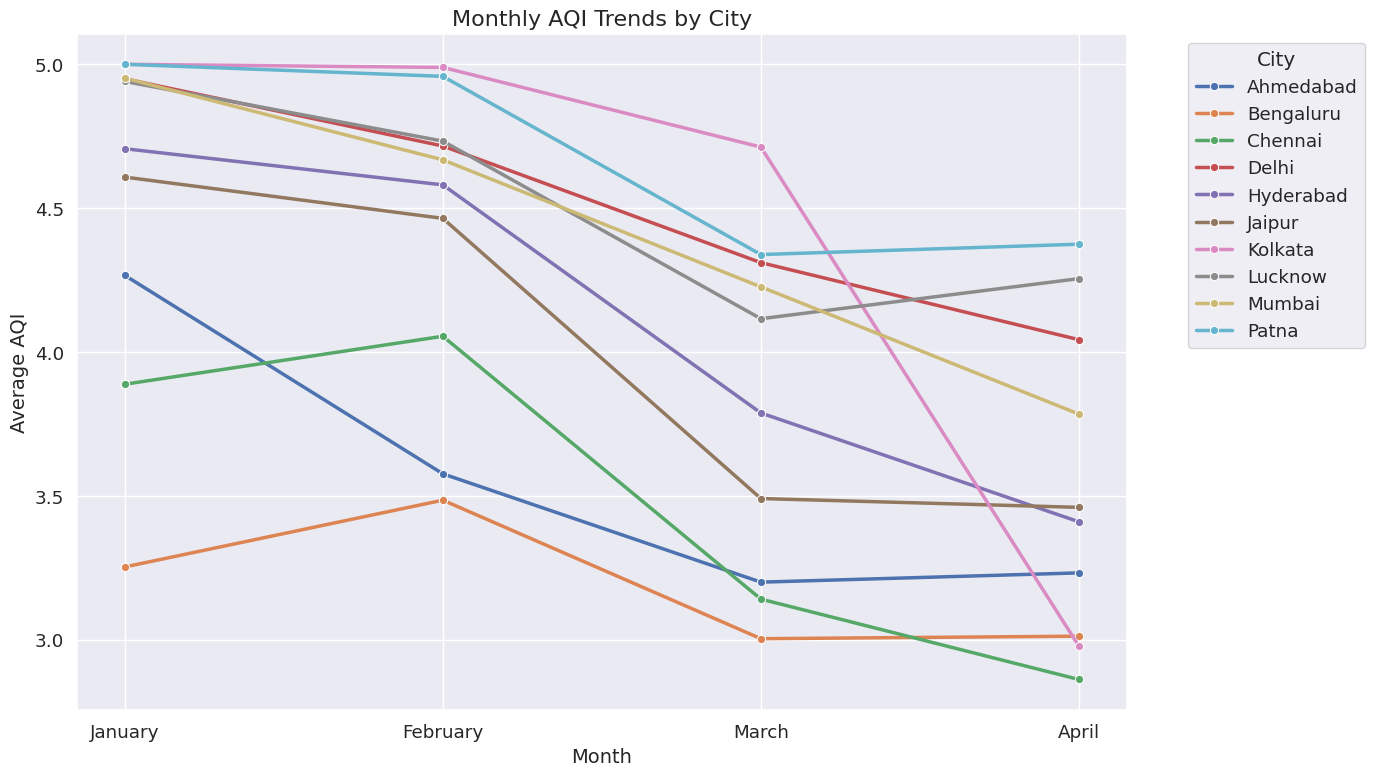

In [ ]:
# 2. Monthly AQI Trends by City (Line Plot)
monthly_aqi = df.groupby(['city', 'month'])['aqi'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.lineplot(x='month', y='aqi', hue='city', data=monthly_aqi, marker='o', linewidth=2.5)
plt.title('Monthly AQI Trends by City', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average AQI', fontsize=14)
plt.xticks([1, 2, 3, 4], ['January', 'February', 'March', 'April'])
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


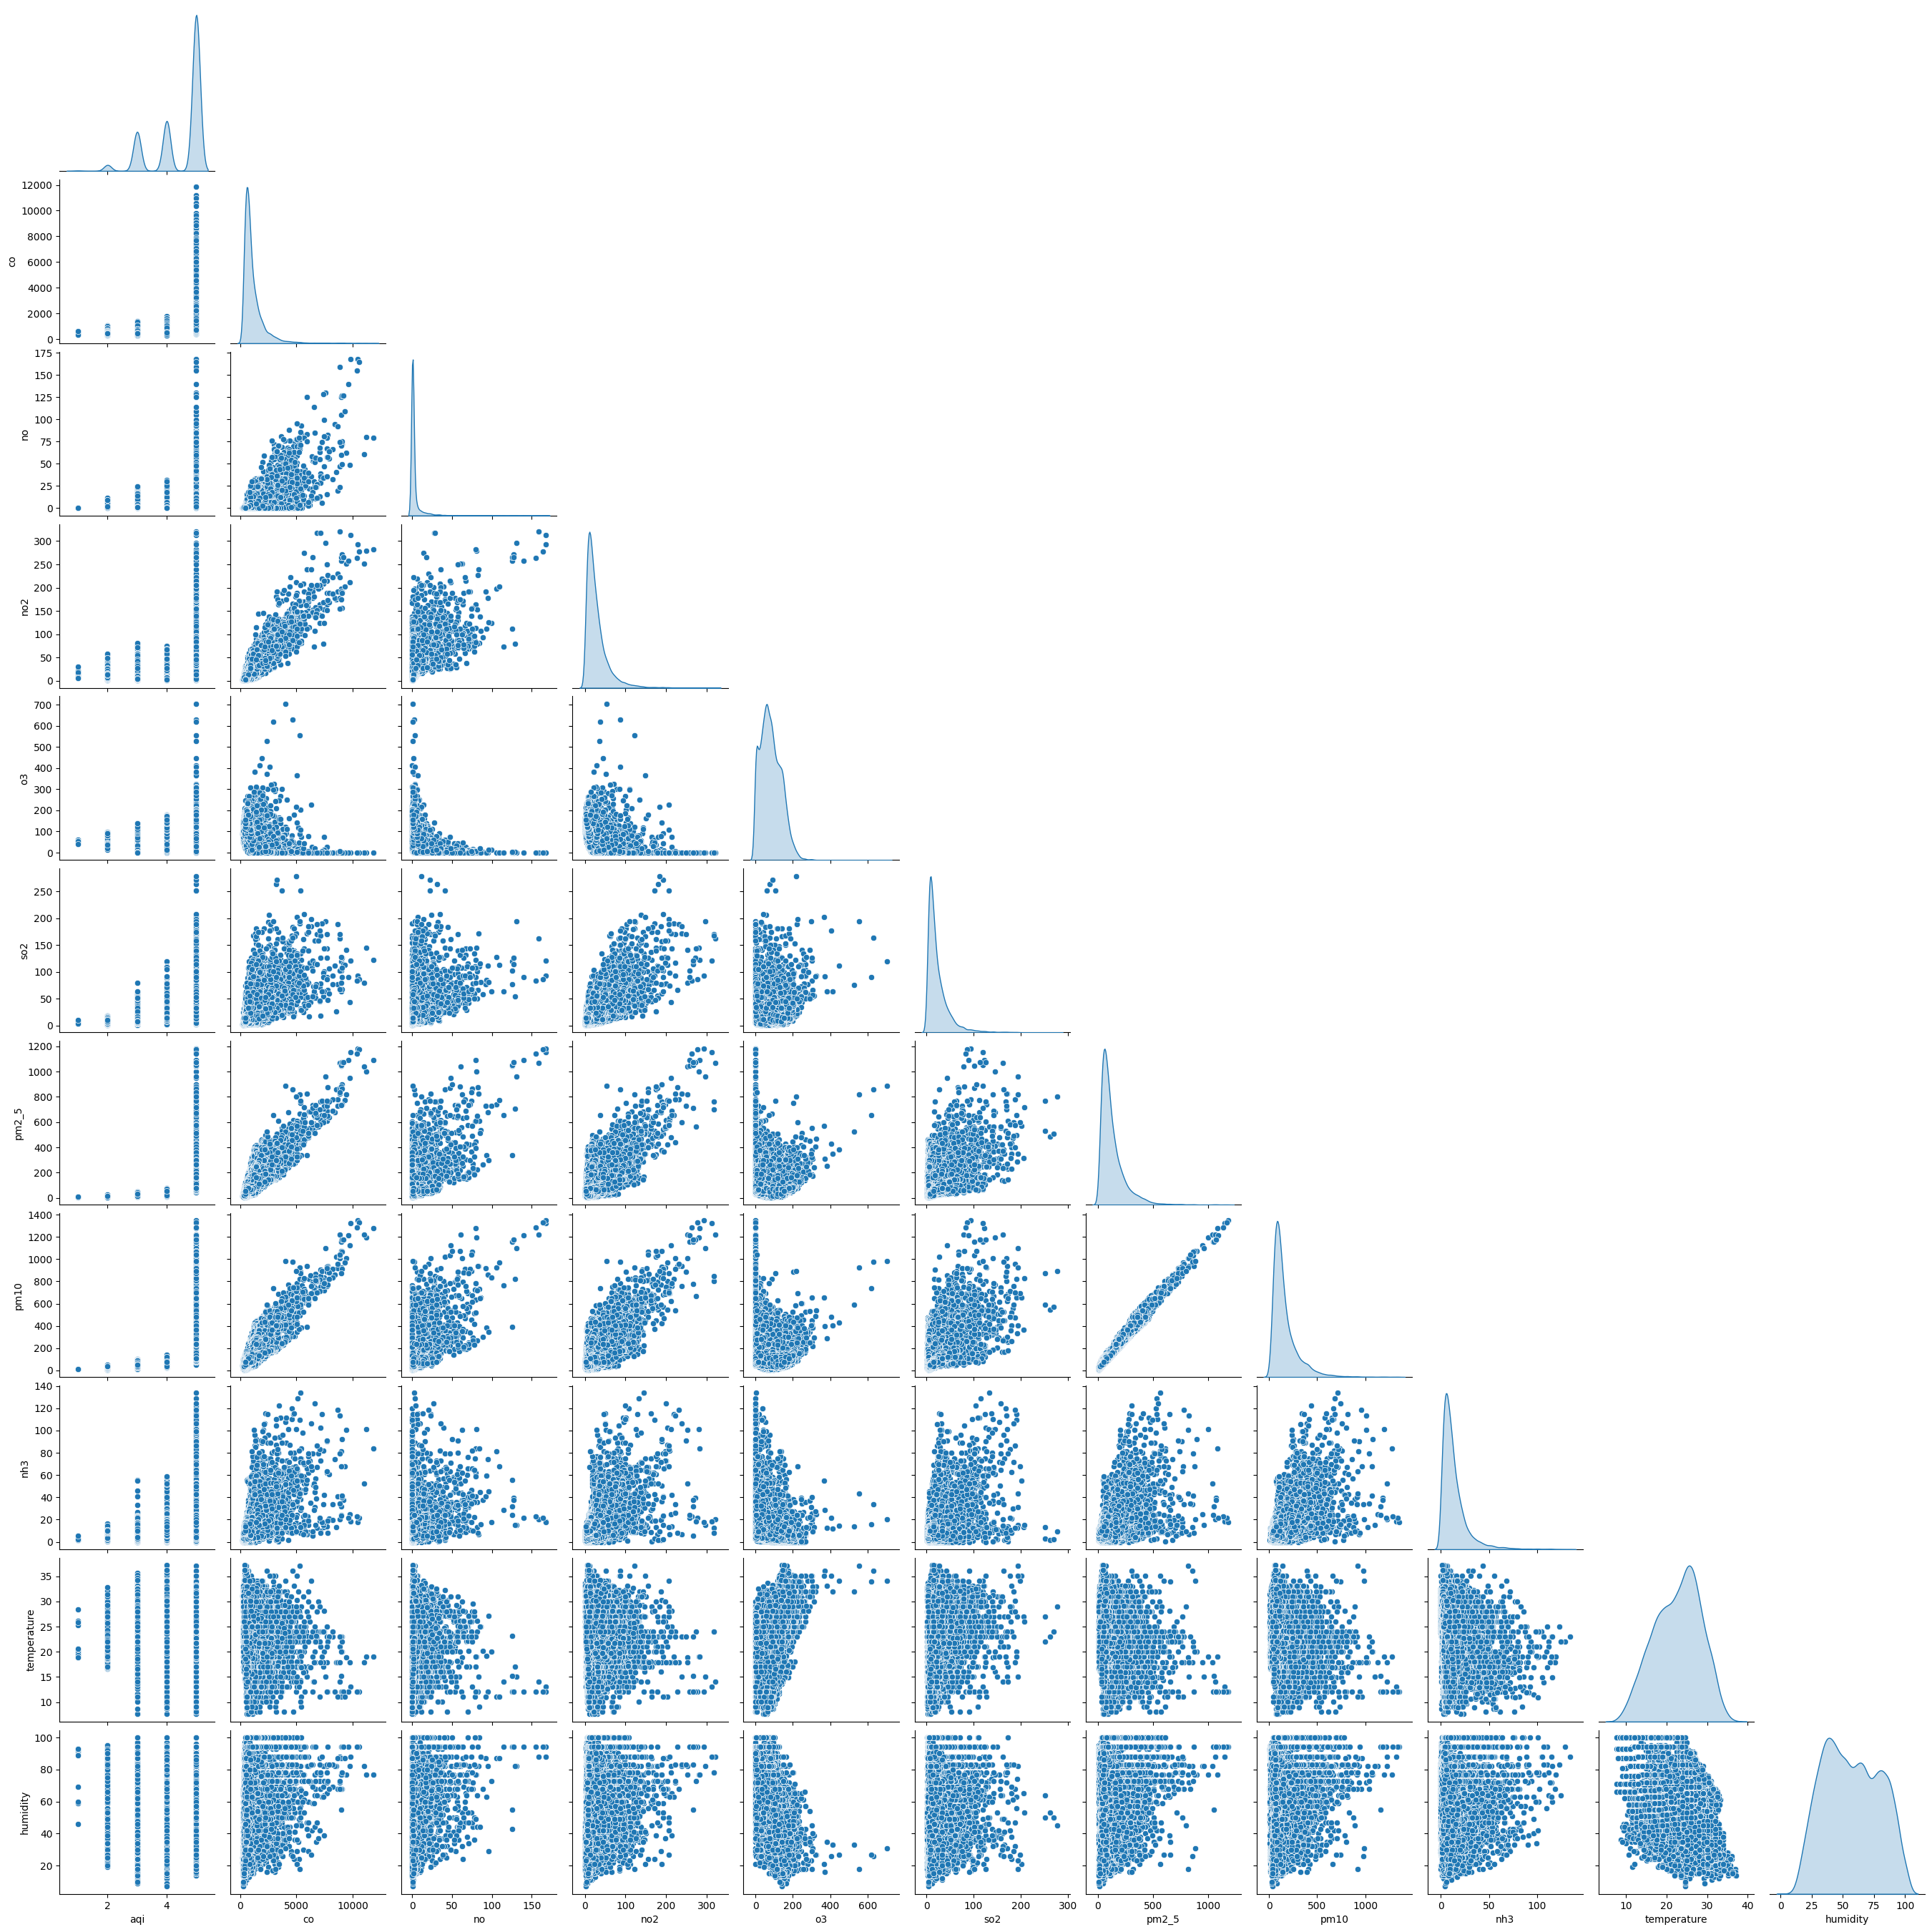

In [ ]:
sns.pairplot(df, diag_kind="kde", corner=True)
plt.show()


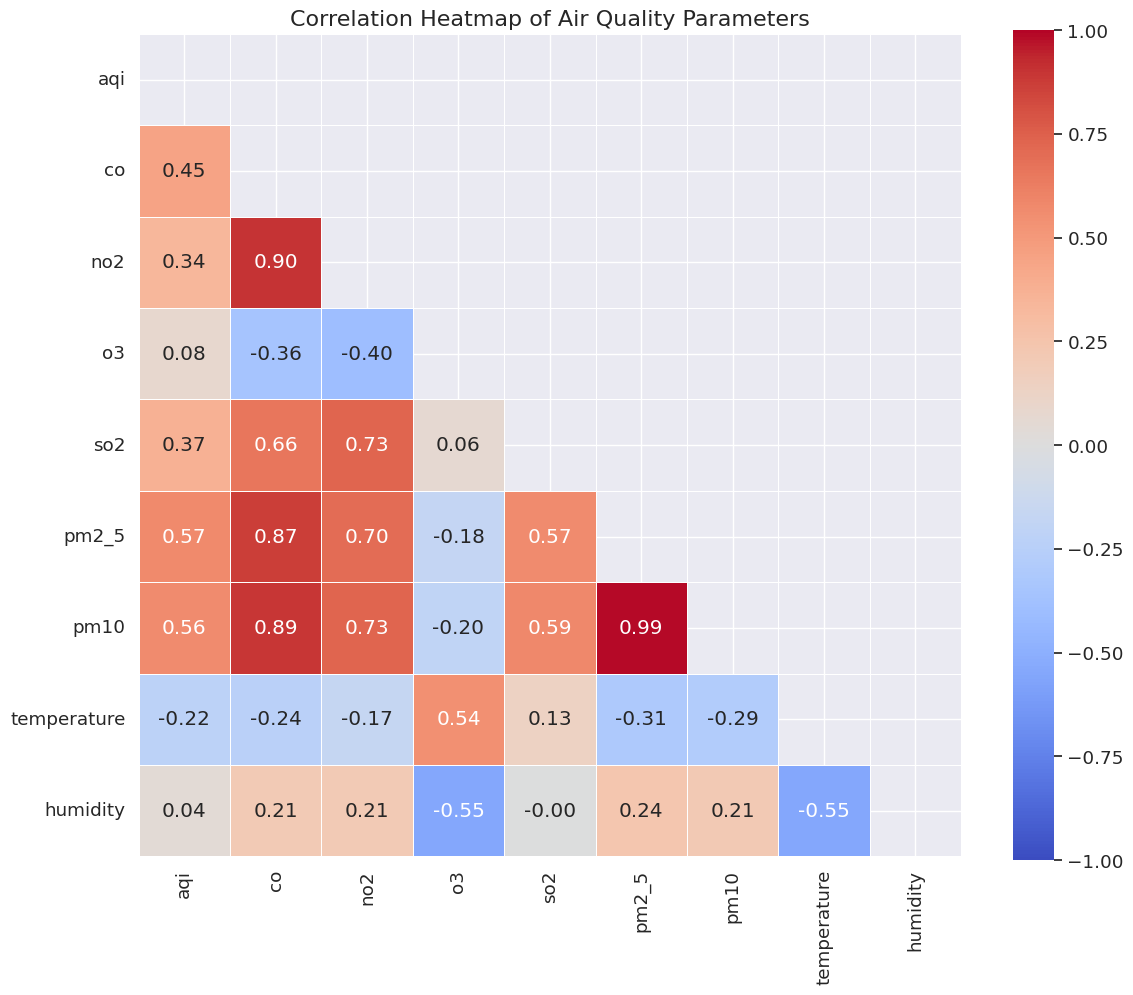

In [ ]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = df[['aqi', 'co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'temperature', 'humidity']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5,
            vmin=-1, vmax=1, center=0, square=True)
plt.title('Correlation Heatmap of Air Quality Parameters', fontsize=16)
plt.tight_layout()
plt.show()


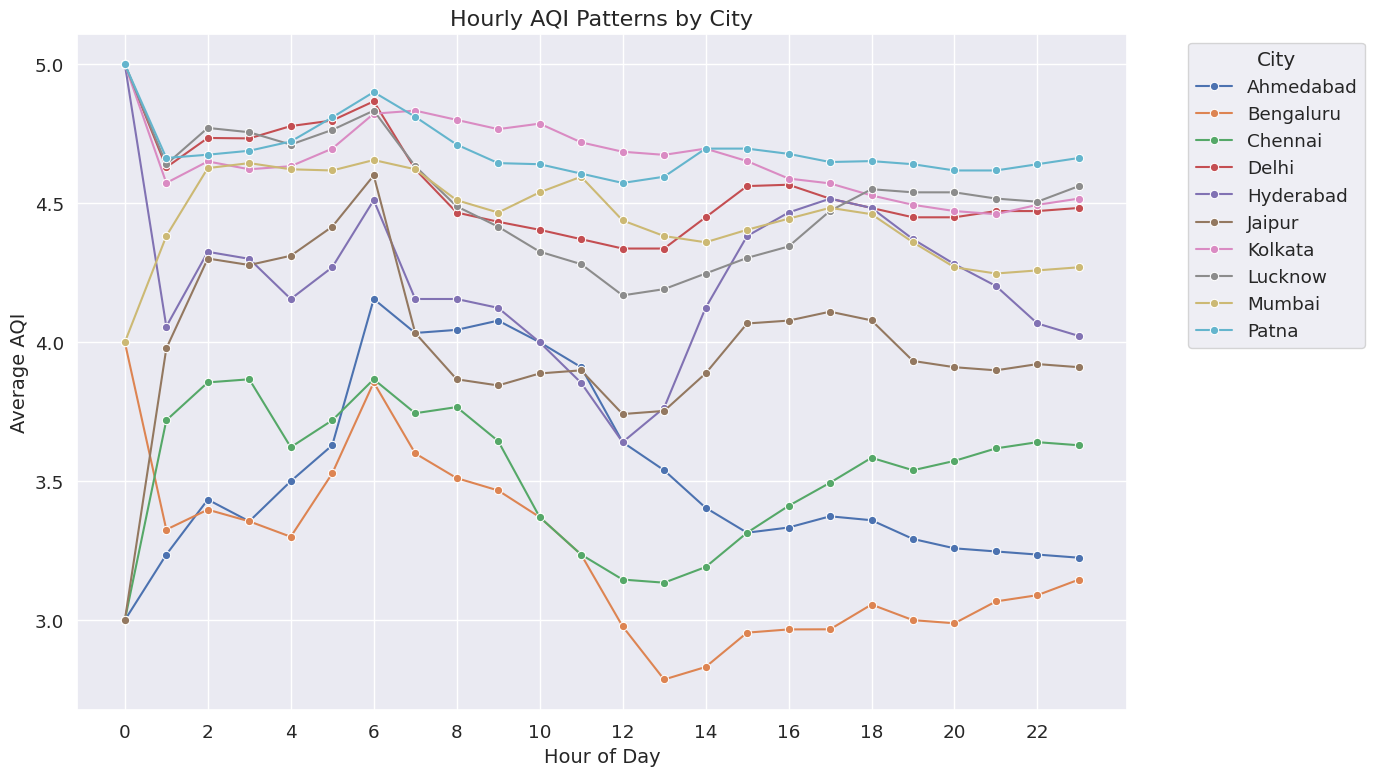

In [ ]:
# 7. Hourly AQI Patterns (Line Plot)
hourly_aqi = df.groupby(['hour', 'city'])['aqi'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.lineplot(x='hour', y='aqi', hue='city', data=hourly_aqi, marker='o')
plt.title('Hourly AQI Patterns by City', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Average AQI', fontsize=14)
plt.xticks(range(0, 24, 2))
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

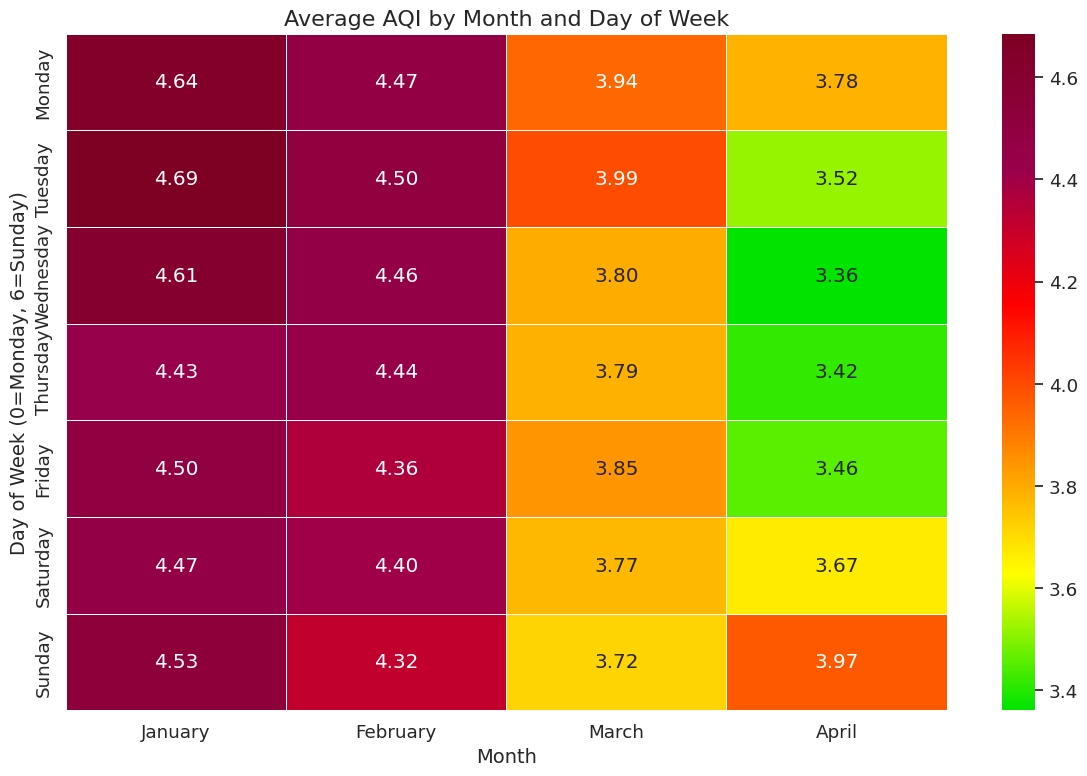

In [ ]:

# 10. Heatmap of AQI by Month and Day of Week
pivot_table = df.pivot_table(values='aqi', index='day_of_week', columns='month', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap=aqi_cmap, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Average AQI by Month and Day of Week', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Day of Week (0=Monday, 6=Sunday)', fontsize=14)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['January', 'February', 'March', 'April'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()
plt.show()

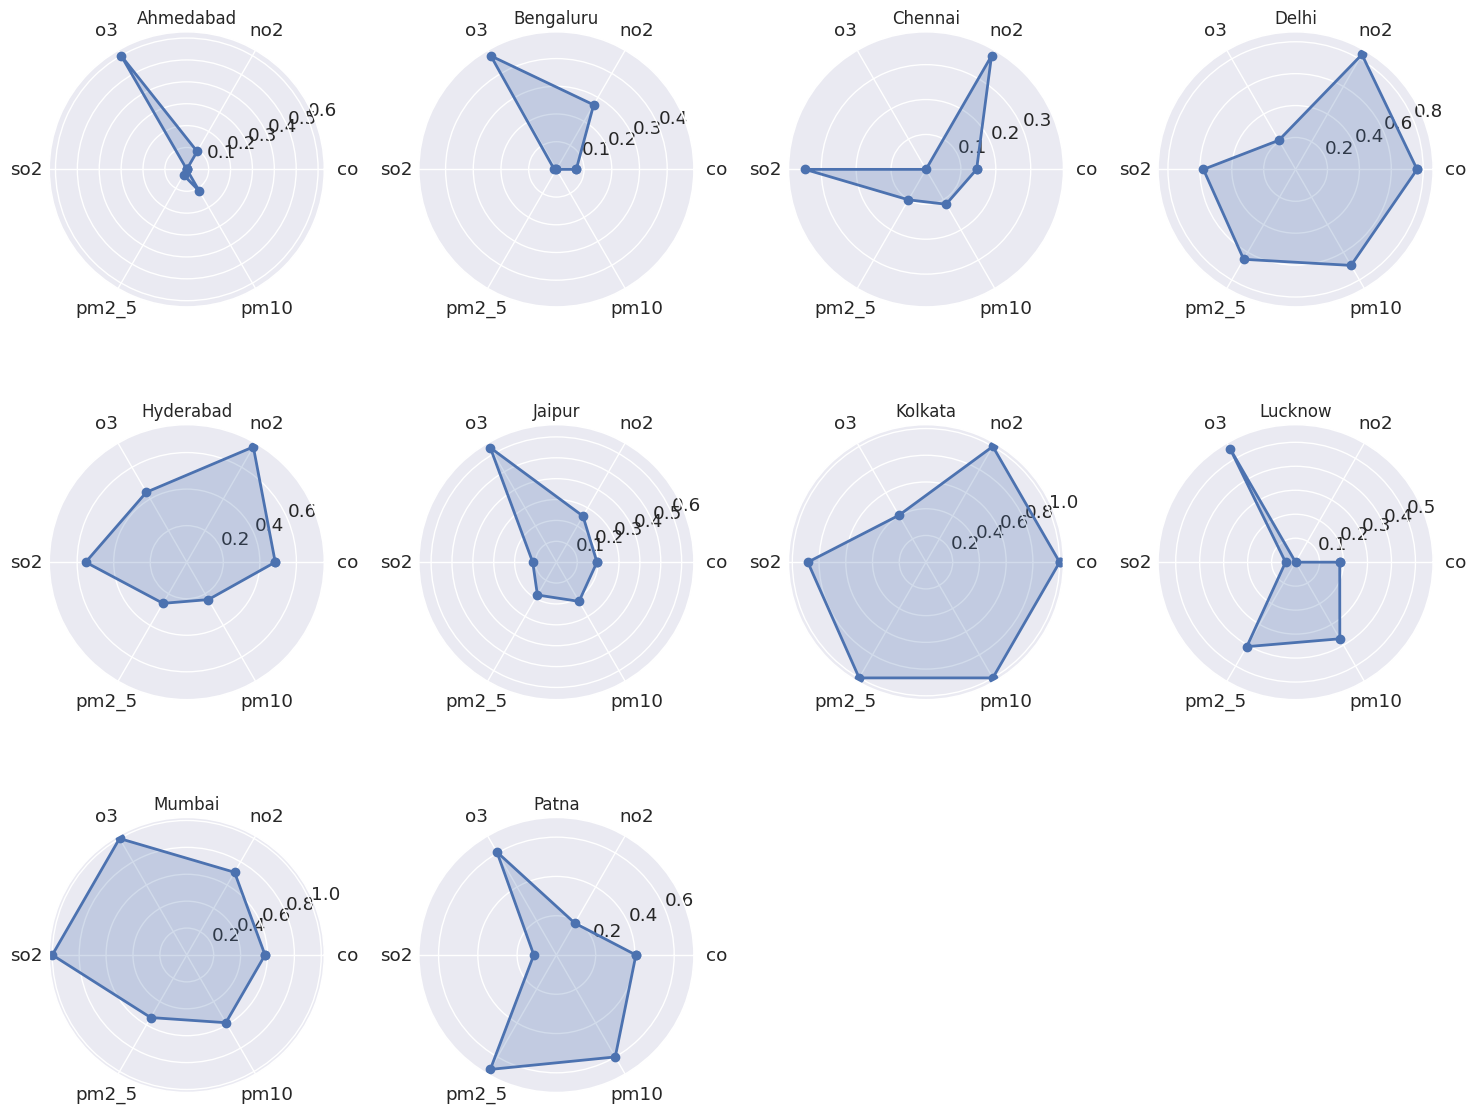

In [ ]:

# 1. Radar Chart of Pollutants by City
# Prepare data for radar chart
pollutants = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10']
city_pollutants = df.groupby('city')[pollutants].mean()

# Normalize the data for better visualization
scaler = MinMaxScaler()
city_pollutants_scaled = pd.DataFrame(
    scaler.fit_transform(city_pollutants),
    columns=city_pollutants.columns,
    index=city_pollutants.index
)

# Create radar chart
fig = plt.figure(figsize=(15, 12))
for i, city in enumerate(city_pollutants_scaled.index):
    ax = fig.add_subplot(3, 4, i+1, polar=True)
    values = city_pollutants_scaled.loc[city].values
    angles = np.linspace(0, 2*np.pi, len(pollutants), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))  # Close the loop
    angles = np.concatenate((angles, [angles[0]]))  # Close the loop

    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), pollutants)
    ax.set_title(city, fontsize=12)
    ax.grid(True)

plt.tight_layout()
plt.show()


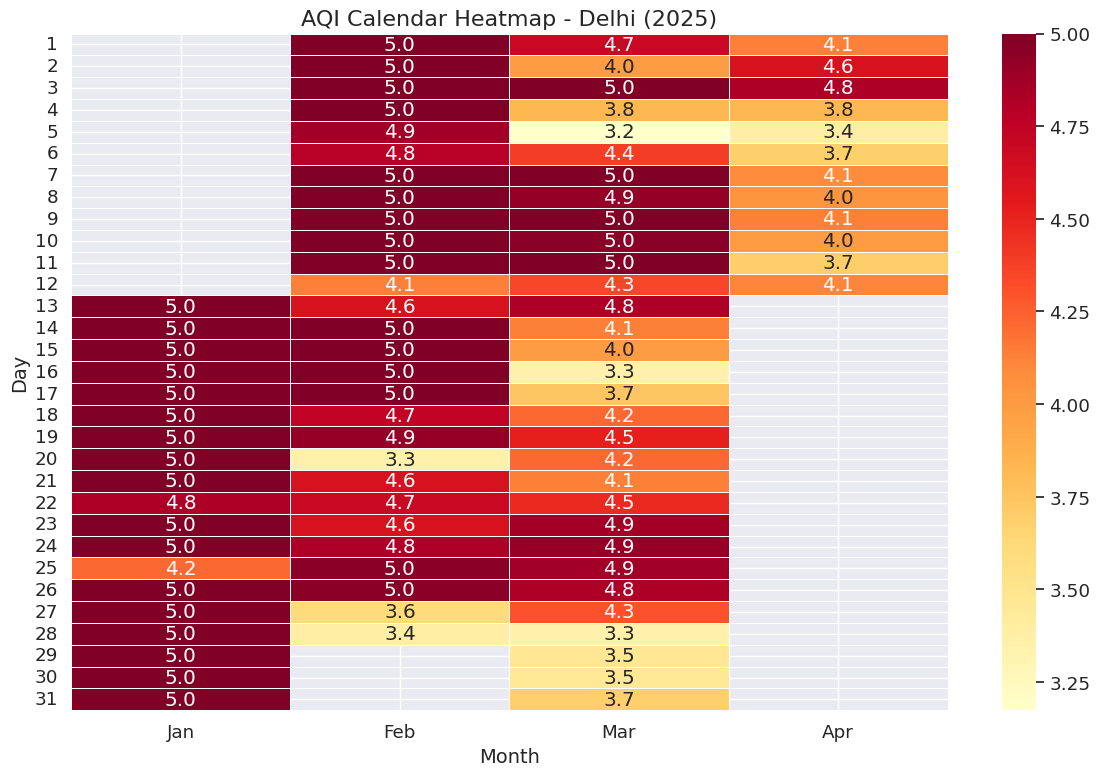

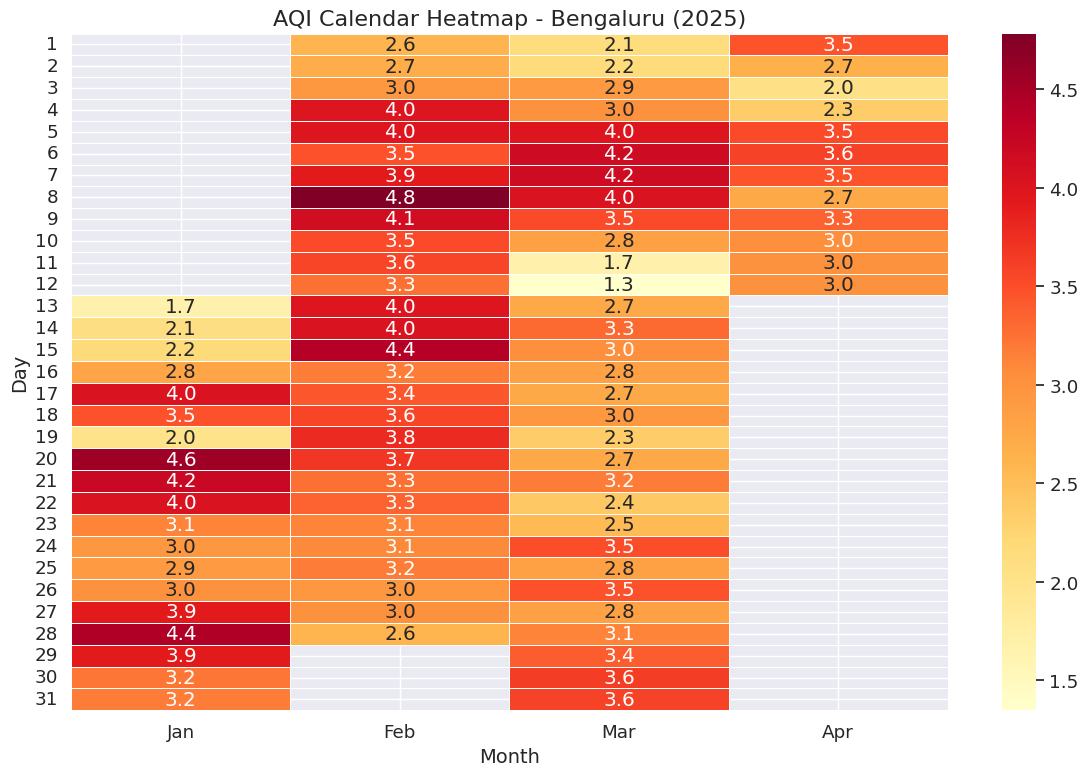

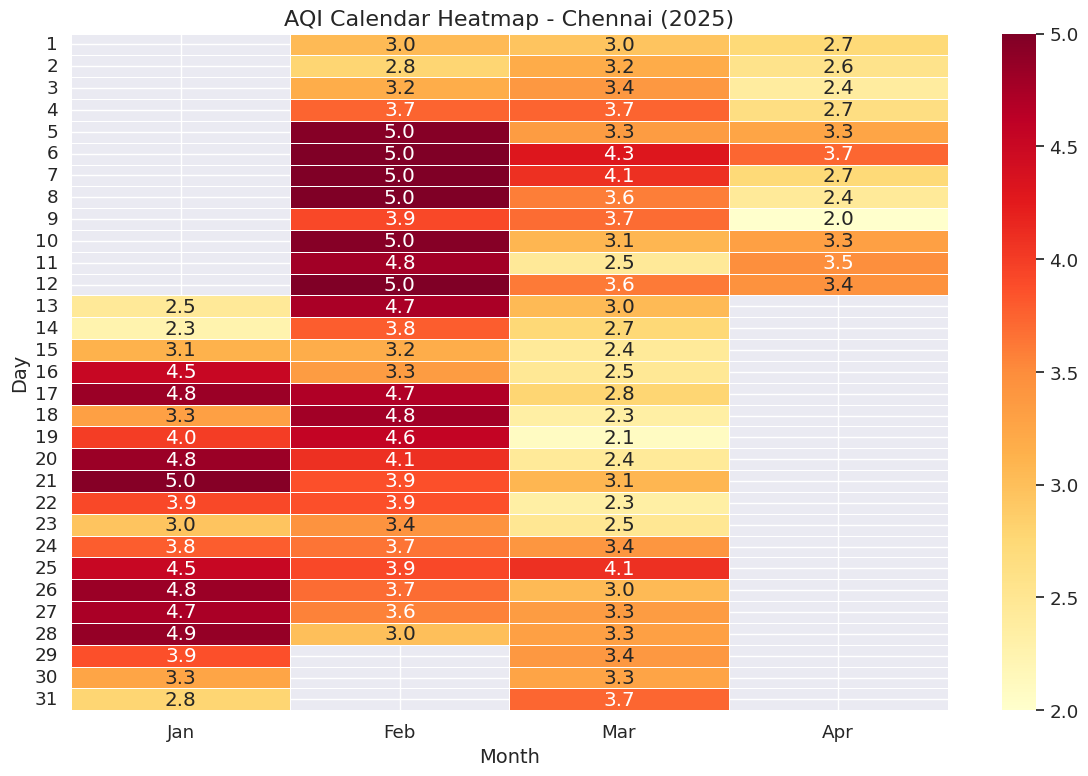

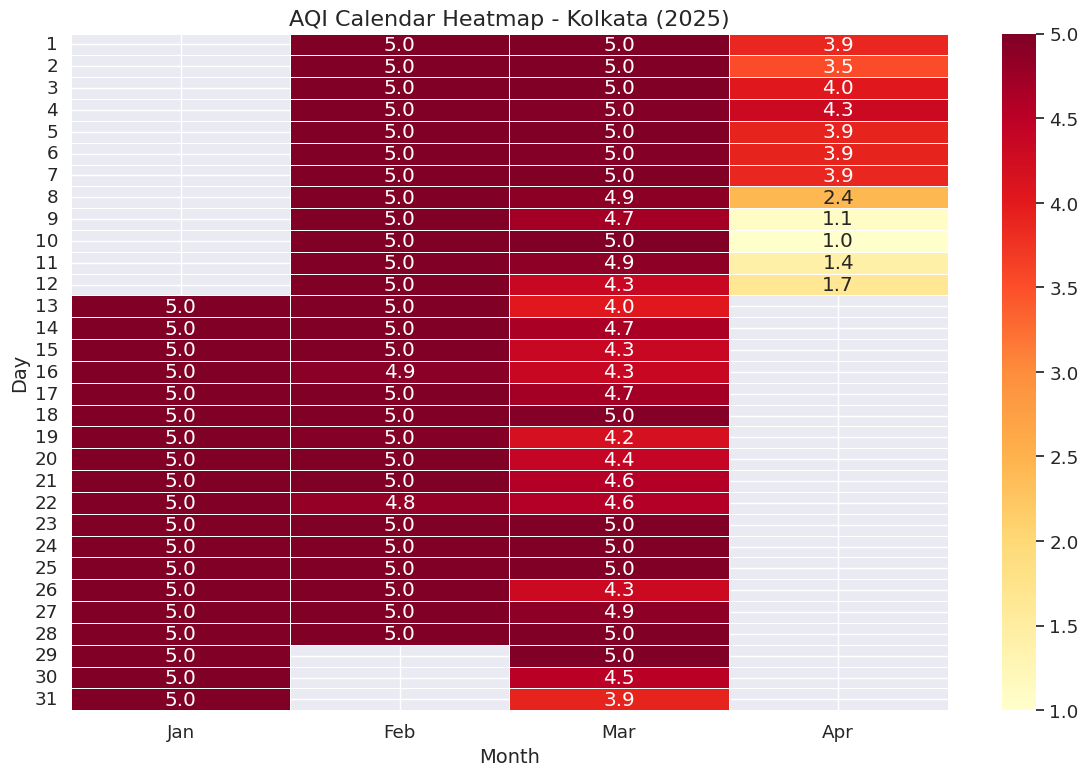

In [ ]:

# 4. Calendar Heatmap of AQI
# Function to create calendar heatmap
def create_calendar_heatmap(data, city, year, month_range):
    # Filter data for the specific city and time range
    city_data = data[(data['city'] == city)]

    # Create a pivot table with day and month
    calendar_data = city_data.pivot_table(
        index='day', columns='month', values='aqi', aggfunc='mean')

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(calendar_data, cmap='YlOrRd', linewidths=0.5, annot=True, fmt='.1f')

    # Set title and labels
    ax.set_title(f'AQI Calendar Heatmap - {city} ({year})', fontsize=16)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('Day', fontsize=14)

    # Set x-axis labels to month names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticklabels([month_names[m-1] for m in month_range])

    plt.tight_layout()
    return plt

# Create calendar heatmaps for Delhi and Bengaluru (highest and lowest AQI cities)
create_calendar_heatmap(df, 'Delhi', 2025, range(1, 5))
plt.show()

create_calendar_heatmap(df, 'Bengaluru', 2025, range(1, 5))
plt.show()


create_calendar_heatmap(df, 'Chennai', 2025, range(1, 5))
plt.show()


create_calendar_heatmap(df, 'Kolkata', 2025, range(1, 5))
plt.show()

Training Random Forest model...
Random Forest - MSE: 0.0008, R²: 0.9992


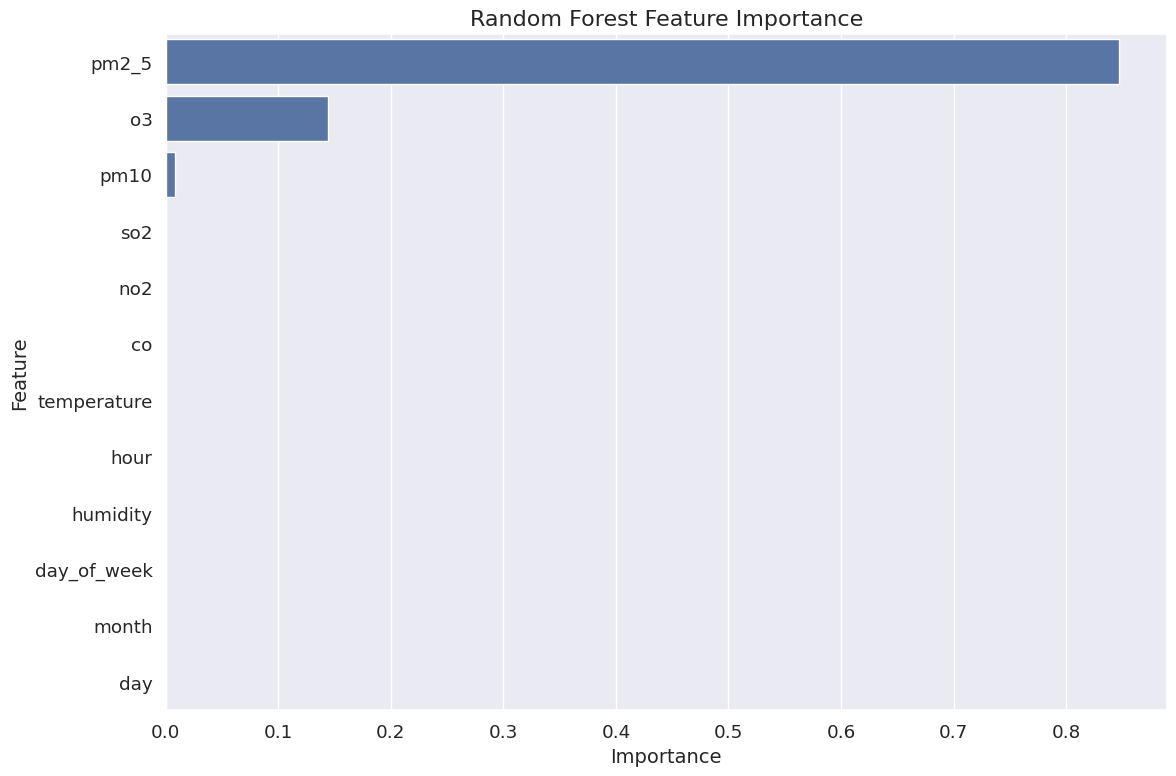

In [ ]:

"""
# FEATURE IMPORTANCE ANALYSIS
"""

# Define features and target
features = ['co', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'temperature', 'humidity',
            'hour', 'day', 'month', 'day_of_week']
X = df[features]
y = df['aqi']

# Drop any rows with missing values
df_clean = df.dropna()
X = df_clean[features]
y = df_clean['aqi']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a DataFrame with scaled features for better interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

# 1. Random Forest Feature Importance
print("Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")

# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
rf_importances = rf_importances.sort_values('Importance', ascending=False)

# Plot Random Forest feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importances)
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


Training Gradient Boosting model...
Gradient Boosting - MSE: 0.0018, R²: 0.9981


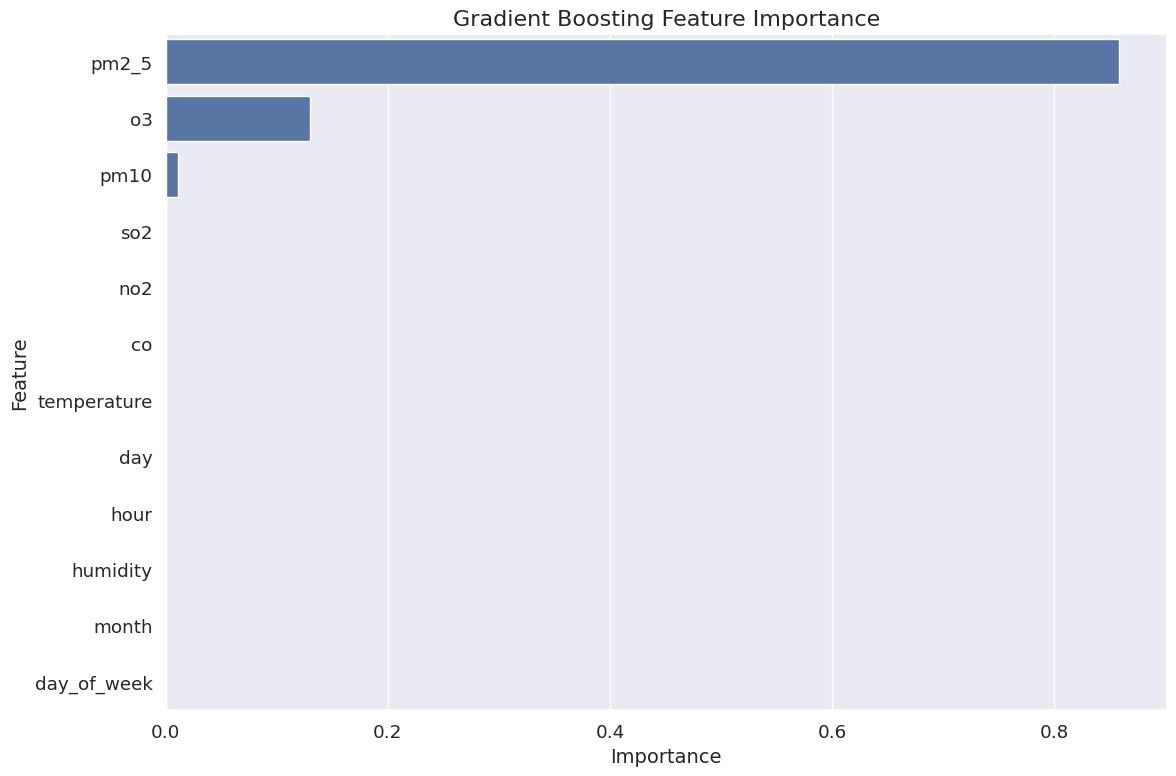

In [ ]:

# 2. Gradient Boosting Feature Importance
print("Training Gradient Boosting model...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_gb = gb_model.predict(X_test_scaled)
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - MSE: {gb_mse:.4f}, R²: {gb_r2:.4f}")

# Get feature importances
gb_importances = pd.DataFrame({
    'Feature': features,
    'Importance': gb_model.feature_importances_
})
gb_importances = gb_importances.sort_values('Importance', ascending=False)

# Plot Gradient Boosting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=gb_importances)
plt.title('Gradient Boosting Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


Analyzing city-specific feature importance...


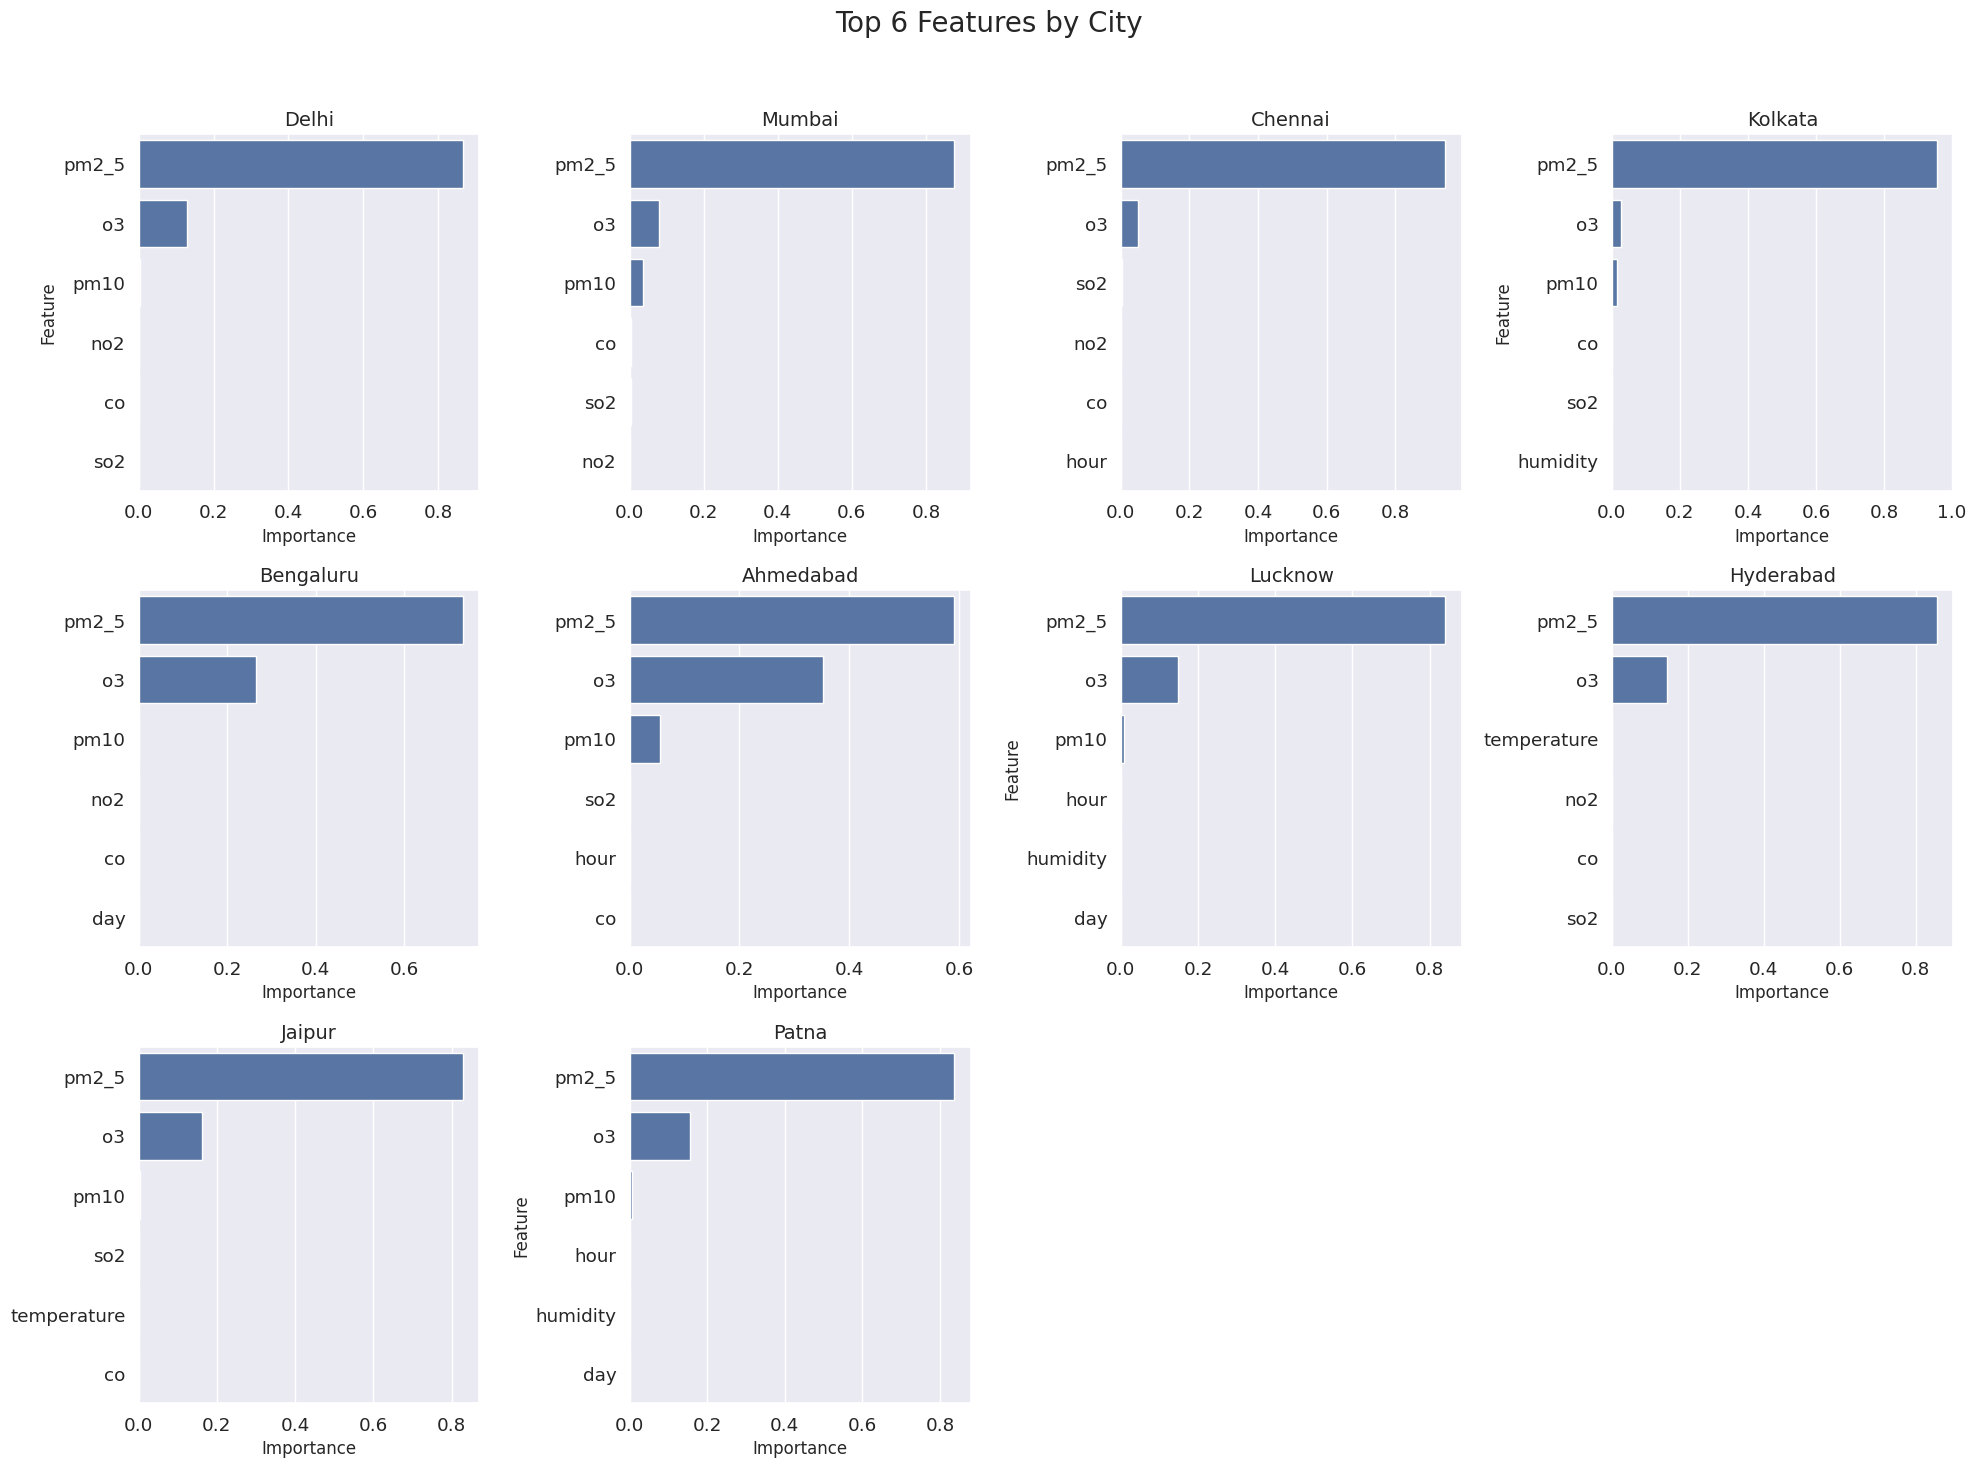

In [ ]:

# 6. City-specific Feature Importance
print("Analyzing city-specific feature importance...")
# Function to get feature importance for a specific city
def get_city_importance(city_name):
    city_data = df[df['city'] == city_name]
    X_city = city_data[features]
    y_city = city_data['aqi']

    # Drop any rows with missing values
    mask = ~np.isnan(X_city).any(axis=1) & ~np.isnan(y_city)
    X_city = X_city[mask]
    y_city = y_city[mask]

    if len(X_city) == 0:
        return pd.DataFrame({'Feature': features, 'Importance': np.zeros(len(features))})

    # Scale features
    X_city_scaled = scaler.transform(X_city)

    # Train a Random Forest model
    rf_city = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_city.fit(X_city_scaled, y_city)

    # Get feature importances
    importances = pd.DataFrame({
        'Feature': features,
        'Importance': rf_city.feature_importances_
    })
    return importances.sort_values('Importance', ascending=False)

# Get feature importance for each city
cities = df['city'].unique()
city_importances = {}

plt.figure(figsize=(20, 15))
for i, city in enumerate(cities):
    city_imp = get_city_importance(city)
    city_importances[city] = city_imp

    # Plot in a grid
    plt.subplot(3, 4, i+1)
    sns.barplot(x='Importance', y='Feature', data=city_imp.head(6))
    plt.title(f'{city}', fontsize=14)
    if i % 3 == 0:  # Only show y-labels for leftmost plots
        plt.ylabel('Feature', fontsize=12)
    else:
        plt.ylabel('')
    plt.xlabel('Importance', fontsize=12)

plt.suptitle('Top 6 Features by City', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Analyzing feature importance for high AQI prediction...


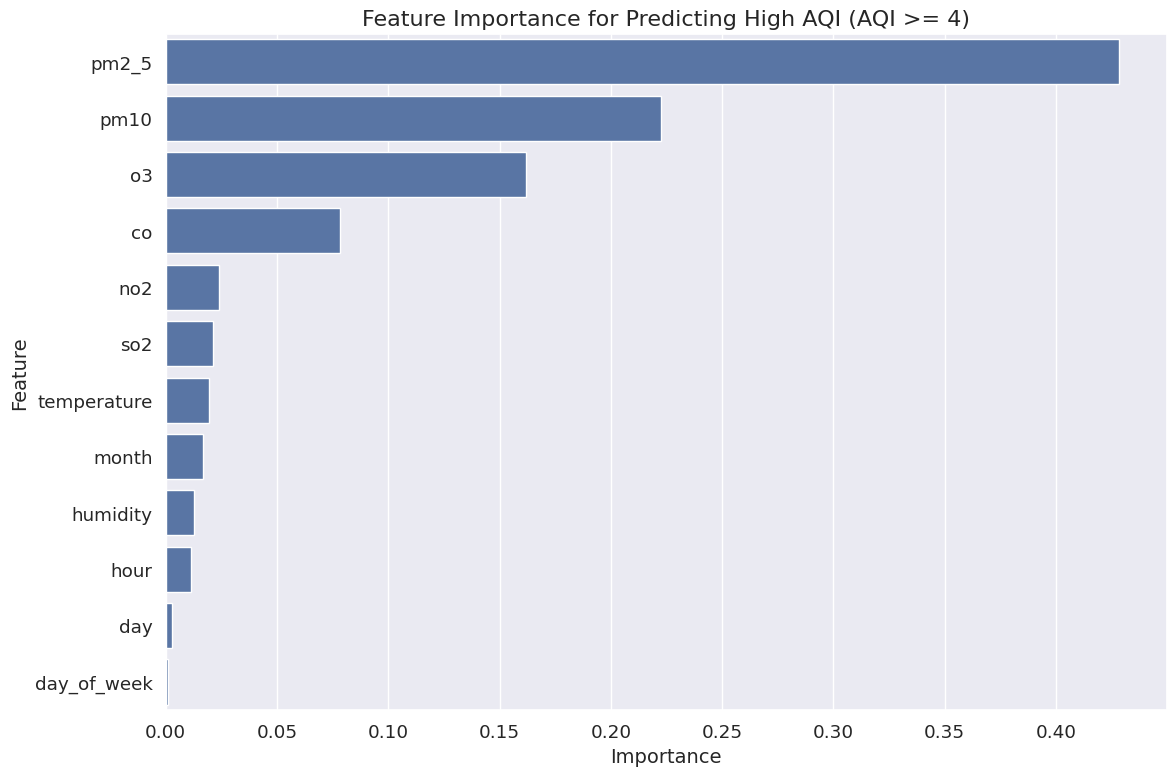

In [ ]:

# 7. Feature Importance for Predicting High AQI (AQI >= 4)
print("Analyzing feature importance for high AQI prediction...")
# Create binary target for high AQI
df['high_aqi'] = (df['aqi'] >= 4).astype(int)

# Define features and target for high AQI prediction
X_high = df[features]
y_high = df['high_aqi']

# Drop any rows with missing values
mask = ~np.isnan(X_high).any(axis=1) & ~np.isnan(y_high)
X_high = X_high[mask]
y_high = y_high[mask]

# Split the data
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(
    X_high, y_high, test_size=0.2, random_state=42)

# Scale the features
X_train_high_scaled = scaler.transform(X_train_high)
X_test_high_scaled = scaler.transform(X_test_high)

# Train Random Forest for high AQI prediction
from sklearn.ensemble import RandomForestClassifier
rf_high = RandomForestClassifier(n_estimators=100, random_state=42)
rf_high.fit(X_train_high_scaled, y_train_high)

# Get feature importances for high AQI prediction
high_aqi_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_high.feature_importances_
})
high_aqi_importances = high_aqi_importances.sort_values('Importance', ascending=False)

# Plot feature importances for high AQI prediction
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=high_aqi_importances)
plt.title('Feature Importance for Predicting High AQI (AQI >= 4)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()
